## Import required libraries

In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import json
# plotting
import matplotlib.pyplot as plt
#opening data
import os
import pathlib
import warnings
#used for plots
from mplsoccer import Pitch
from scipy.stats import binned_statistic_2d
import glob

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

## Import all events per Man City's matches

In [2]:
# Define the wildcard pattern to match the file names
pattern = '../data/StatsBomb/Data/*_events.json'
# Use glob to find all files that match the pattern
file_list = glob.glob(pattern)

In [3]:
file_list

['../data/StatsBomb/Data/ManCity_Tottenham_events.json',
 '../data/StatsBomb/Data/ManCity_AstonVilla_events.json',
 '../data/StatsBomb/Data/ManCity_Liverpool_events.json',
 '../data/StatsBomb/Data/ManCity_Brighton_events.json',
 '../data/StatsBomb/Data/ManCity_Arsenal_events.json',
 '../data/StatsBomb/Data/ManCity_LeicesterCity_events.json']

In [4]:
df_list = []
for file in file_list:
    # Open the file and load its contents into a dictionary
    with open(file, 'r') as f:
        data = json.load(f)
        # Convert the list of JSON values to a DataFrame
        df_list.append(pd.json_normalize(data))

In [5]:
df = pd.concat(df_list,ignore_index = True)

## Import all lineups per Man City's matches

In [300]:
# # Define the wildcard pattern to match the file names
# pattern = '../data/StatsBomb/Data/*_lineups.json'
# # Use glob to find all files that match the pattern
# file_list = glob.glob(pattern)

# file_list

# df_list = []
# for file in file_list:
#     # Open the file and load its contents into a dictionary
#     with open(file, 'r') as f:
#         data = json.load(f)
#         # Convert the list of JSON values to a DataFrame
#         df_list.append(pd.json_normalize(data))

# df_lineup = pd.concat(df_list,ignore_index = True)

# df_lineup

In [6]:
# df = df[df['possession_team.id'] == 746]
# df = df[df['play_pattern.name']!='From Keeper']
# df = df[df['play_pattern.name']=='Regular Play']

## Actions moving the ball
- To calculate the Expected Threat we need actions that move the ball
- Remove passes that ended out of the pitch
- Create new columns with coordinates, one for each coordinate
- Plot the location of actions moving the ball on 2D histogram.
- Dribbling is also an action that moves the ball

In [7]:
next_event = df.shift(-1, fill_value=0)

In [8]:
df["nextEvent"] = next_event["type.name"]
df['kickedOut'] = np.where(next_event['out']==True,1,0)

In [9]:
#get move_df
move_df = df[df['type.name']=='Pass']
#filtering out of the field
delete_passes = move_df.loc[move_df["kickedOut"] == 1]
move_df = move_df.drop(delete_passes.index)

In [10]:
#extract coordinates
move_df["x"] = move_df['location'].apply(lambda cell: (cell[0]) * 105/100)
move_df["y"] = move_df['location'].apply(lambda cell: (100 - cell[1]) * 68/100)
move_df['end_x'] = move_df['pass.end_location'].apply(lambda cell: (cell[0]) * 105/100)
move_df['end_y'] = move_df['pass.end_location'].apply(lambda cell: (100 - cell[1]) * 68/100)
move_df = move_df.loc[(((move_df["end_x"] != 0) & (move_df["end_y"] != 68)) & ((move_df["end_x"] != 105) & (move_df["end_y"] != 0)))]

In [11]:
#extract coordinates
move_df["x"] = move_df['location'].apply(lambda cell: (cell[0]))
move_df["y"] = move_df['location'].apply(lambda cell: cell[1])
move_df['end_x'] = move_df['pass.end_location'].apply(lambda cell: (cell[0]))
move_df['end_y'] = move_df['pass.end_location'].apply(lambda cell: cell[1])
# move_df = move_df.loc[(((move_df["end_x"] != 0) & (move_df["end_y"] != 68)) & ((move_df["end_x"] != 105) & (move_df["end_y"] != 0)))]

In [12]:
df['play_pattern.name'].value_counts()

Regular Play      9967
From Throw In     5102
From Free Kick    2090
From Goal Kick    1609
From Corner       1028
From Kick Off      803
From Keeper        438
Other              162
From Counter       133
Name: play_pattern.name, dtype: int64

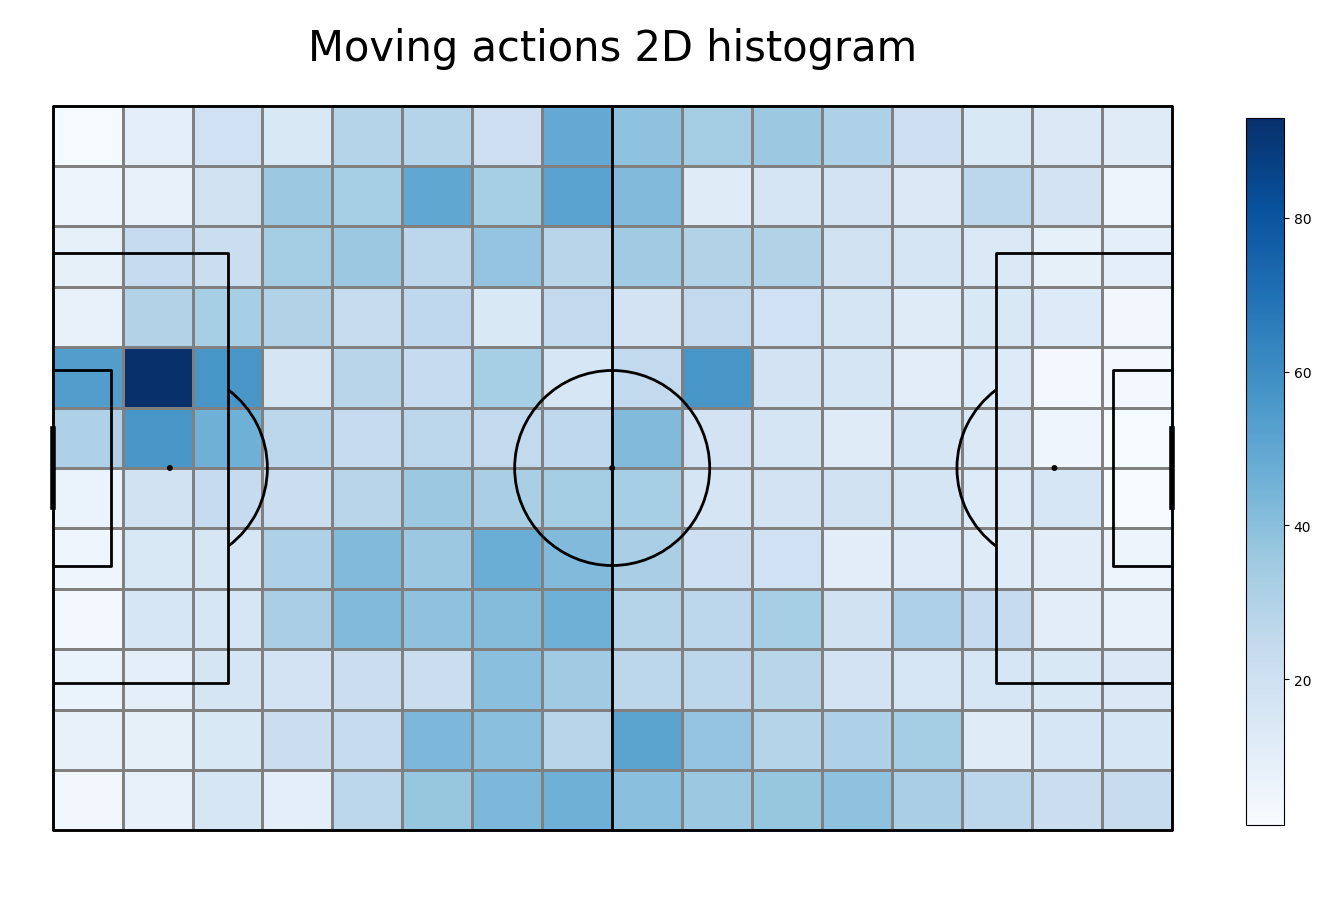

In [13]:
#create 2D histogram of these
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
move = pitch.bin_statistic(move_df.x, move_df.y, statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Moving actions 2D histogram', fontsize = 30)
plt.show()
#get the array
move_count = move["statistic"]

## Collect shots

In [15]:
#get shot df
shot_df = df.loc[df['type.name'] == "Shot"]
shot_df["x"] = shot_df['location'].apply(lambda cell: (cell[0]))
shot_df["y"] = shot_df['location'].apply(lambda cell: cell[1])

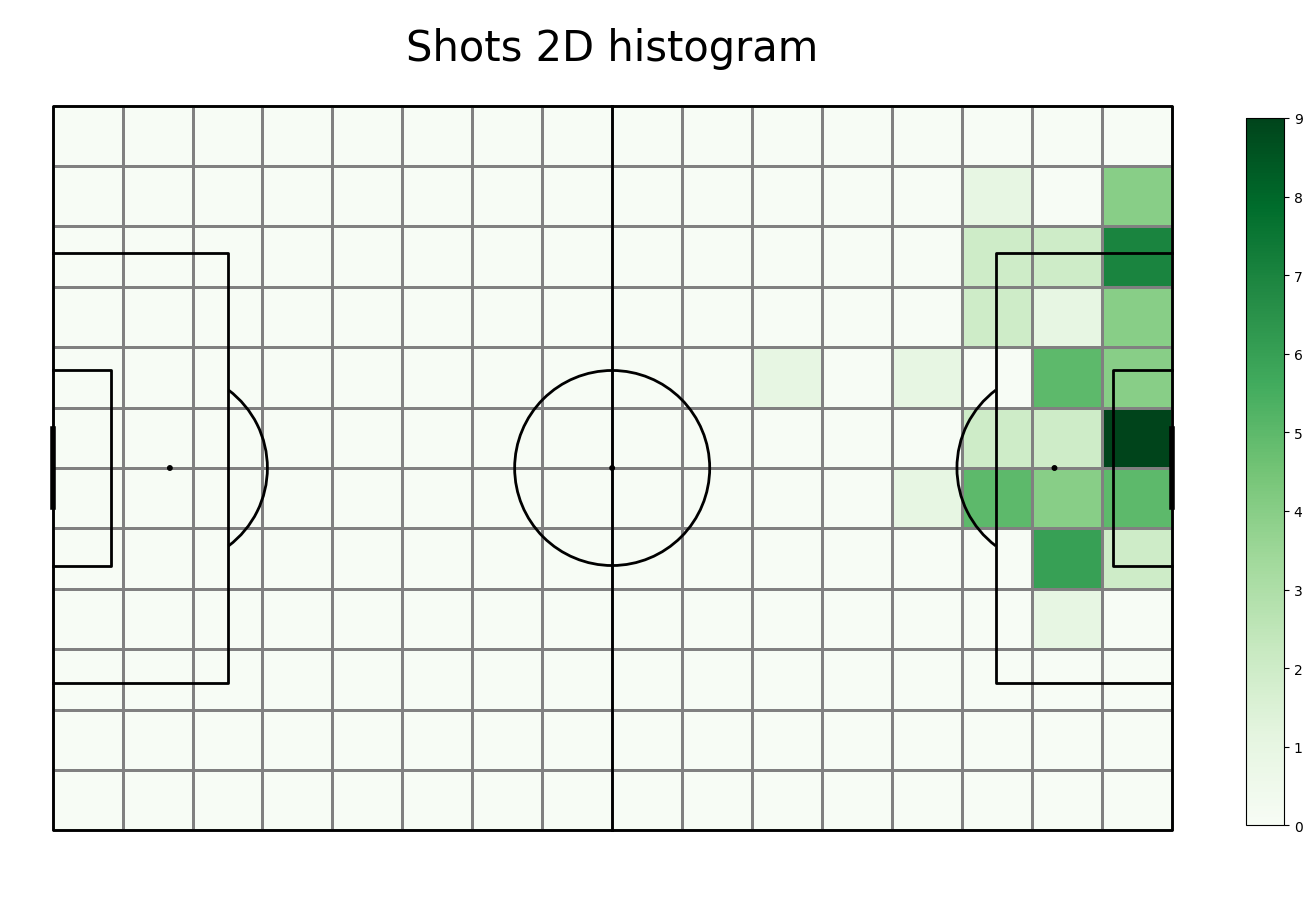

In [16]:
#create 2D histogram of these
shot = pitch.bin_statistic(shot_df.x, shot_df.y, statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shots 2D histogram', fontsize = 30)
plt.show()

shot_count = shot["statistic"]

## Collect Goals

In [21]:
goal_df = shot_df[shot_df['shot.outcome.name']=='Goal']

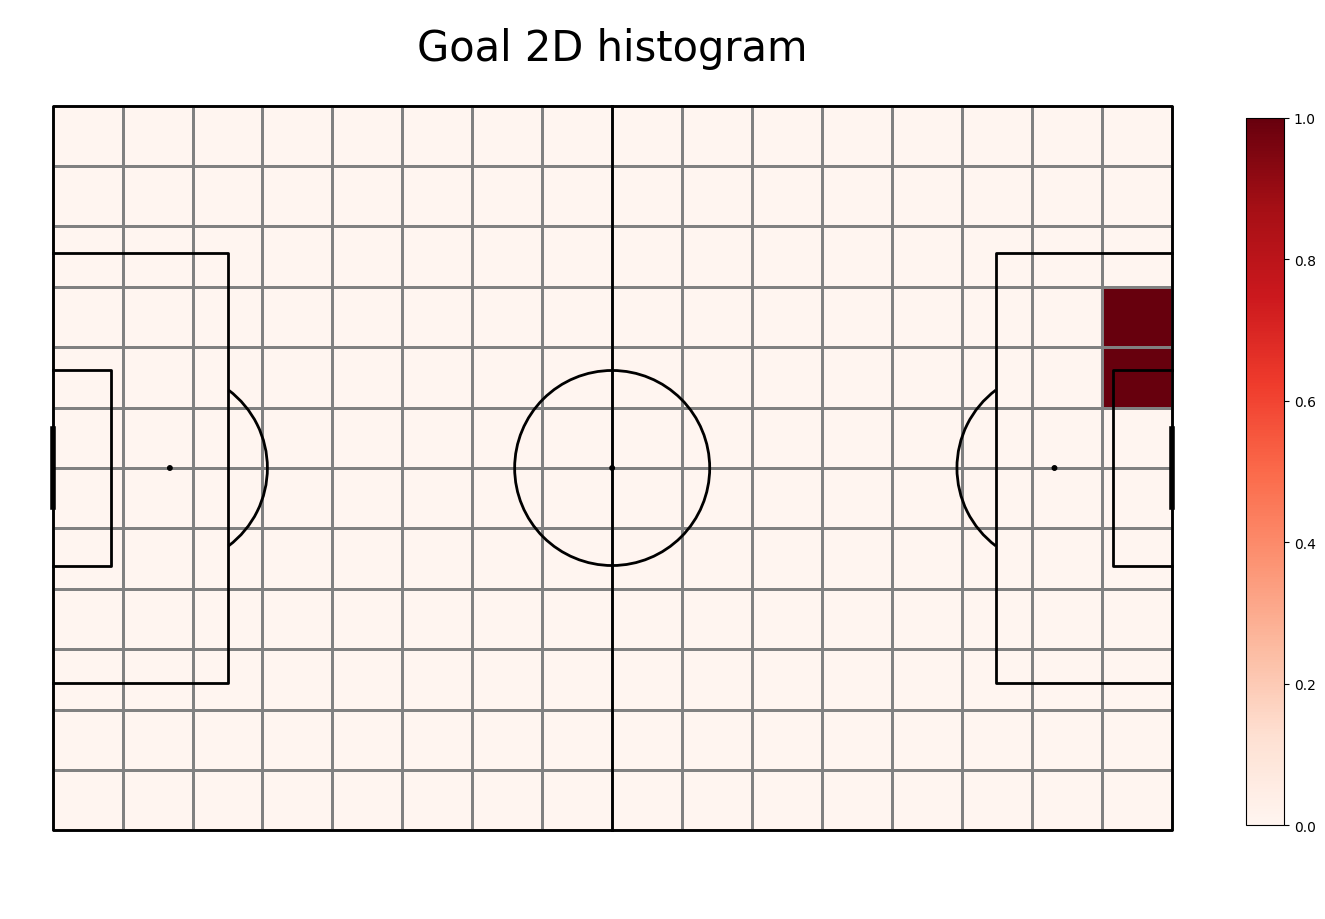

In [22]:
goal = pitch.bin_statistic(goal_df.x, goal_df.y, statistic='count', bins=(16, 12), normalize=False)
goal_count = goal["statistic"]

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal 2D histogram', fontsize = 30)
plt.show()

## Move probability

### Probability of each moving action 
- Calculate the probability of each moving action
- Divide its number in each bin by the sum of moving actions and shots in that bin

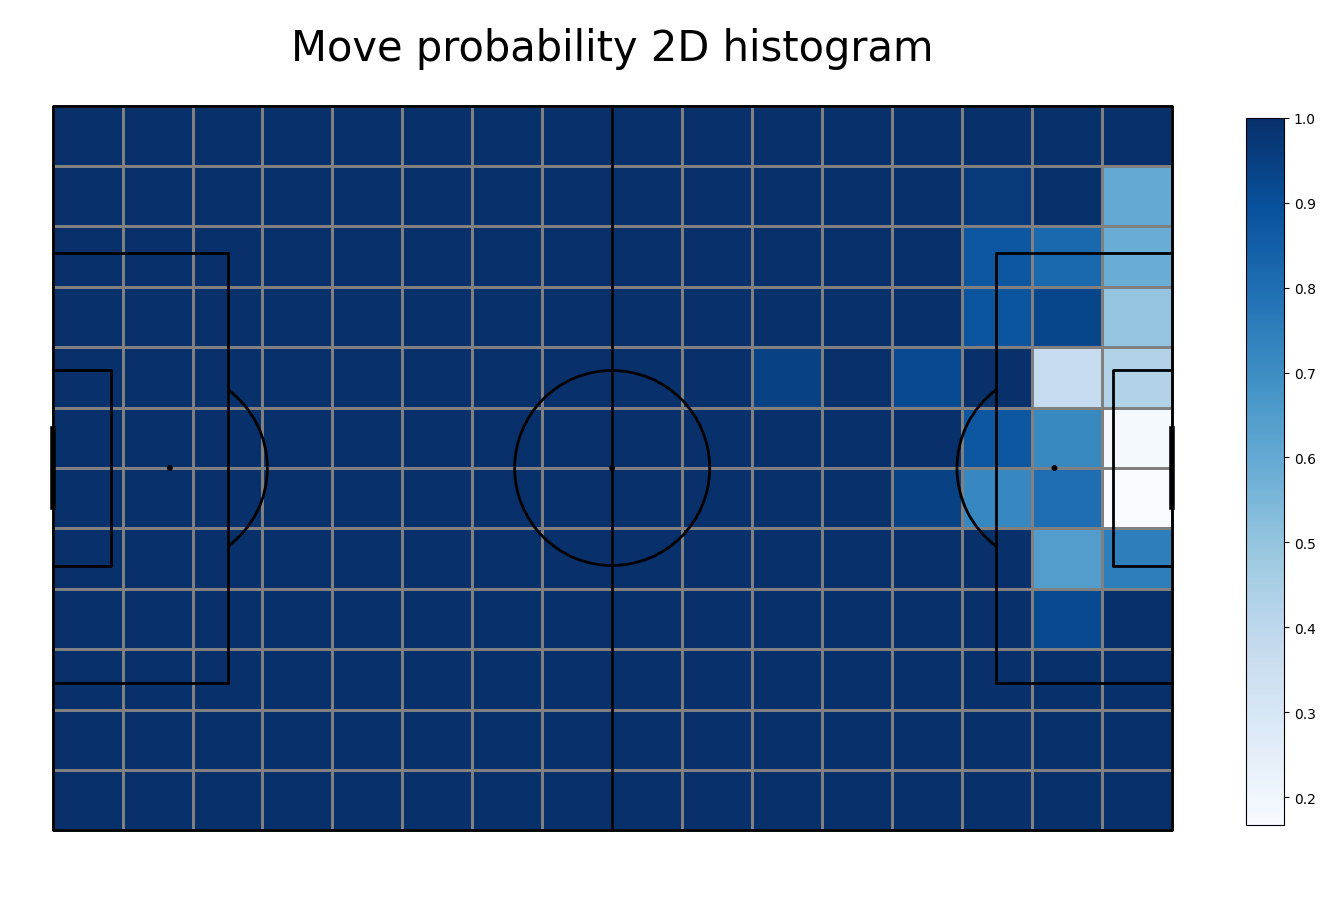

In [24]:
move_probability = move_count/(move_count+shot_count)
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
move["statistic"] = move_probability
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Move probability 2D histogram', fontsize = 30)
plt.show()


### Probability of a shot in each area
- Calculate the probability of a shot in each area
- Divide its number in each bin by the sum of moving actions and shots in that bin

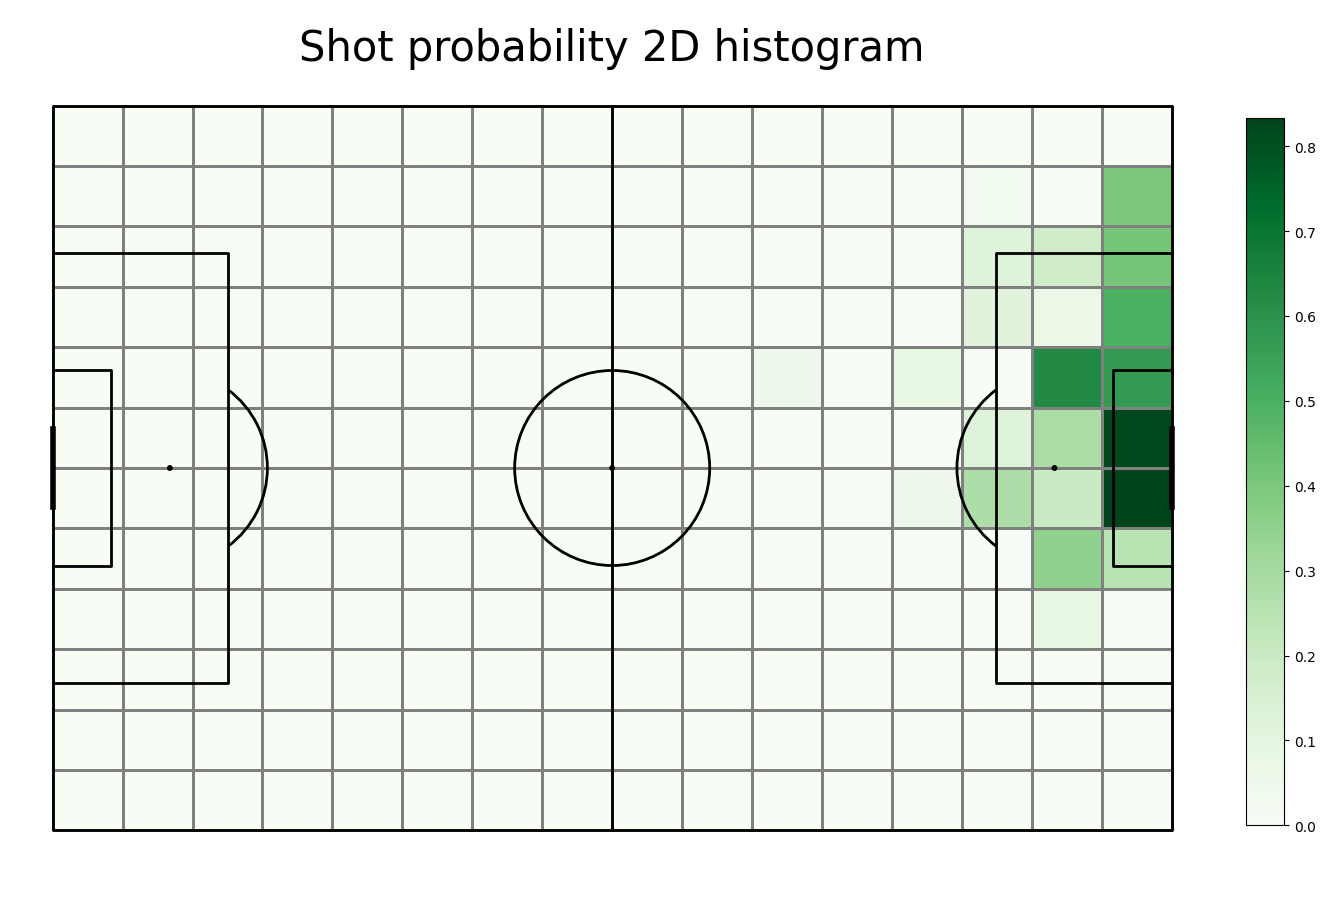

In [25]:
shot_probability = shot_count/(move_count+shot_count)
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
shot["statistic"] = shot_probability
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shot probability 2D histogram', fontsize = 30)
plt.show()

## Goal probability
- Naive way - number of goals in this area divided by number of shots there

In [185]:
goal["statistic"].shape

(12, 16)

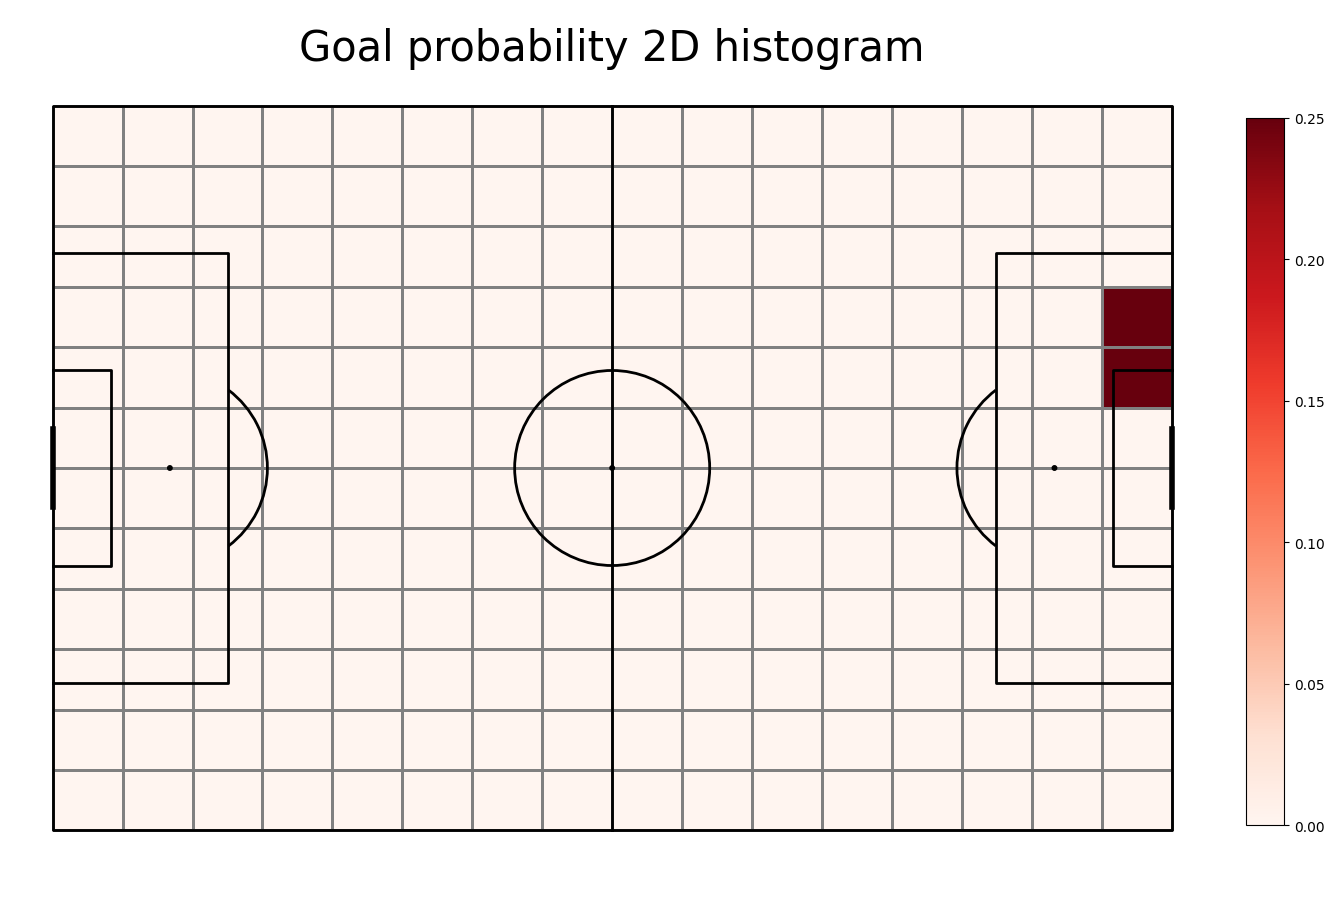

In [186]:
goal_probability = goal_count/shot_count
goal_probability[np.isnan(goal_probability)] = 0
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
goal["statistic"] = goal_probability
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal probability 2D histogram', fontsize = 30)
plt.show()

## Transition matirices
- For each of 192 sectors we need to calculate a transition matrix 
- We create another columns in the move_df with the bin on the histogram that the event started and ended in.
- We group the data by starting sector and count starts from each of them.
- For each of the sectors we calculate the probability of transfering the ball from it to all 192 sectors on the pitch. given that the ball was moved.
- We do it as the division of events that went to the end sector by all events that started in the starting sector.
- We vizualize the transition matrix for the sector in the bottom left corner of the pitch

In [207]:
df_count_starts

,start_sector,count_starts
0,"(1, 1)",4
1,"(1, 2)",8
2,"(1, 3)",7
3,"(1, 4)",3
4,"(1, 5)",5
...,...,...
216,"(17, 9)",4
217,"(17, 10)",16
218,"(17, 11)",14
219,"(17, 12)",19


In [208]:
move_df[['start_sector','end_sector']]

,start_sector,end_sector
4,"(10, 8)","(8, 8)"
7,"(8, 9)","(6, 9)"
10,"(6, 10)","(6, 12)"
13,"(6, 12)","(8, 10)"
17,"(12, 3)","(14, 1)"
...,...,...
21318,"(14, 12)","(16, 10)"
21322,"(15, 11)","(14, 11)"
21324,"(14, 11)","(15, 9)"
21327,"(15, 9)","(17, 11)"


In [260]:
#move start index - using the same function as mplsoccer, it should work
move_df["start_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.x), np.ravel(row.y),
                                                               values = "None", statistic="count",
                                                               bins=(15, 11), range=[[0, 105], [0, 68]],
                                                               expand_binnumbers=True)[3]]), axis = 1)
#move end index
move_df["end_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.end_x), np.ravel(row.end_y),
                                                               values = "None", statistic="count",
                                                               bins=(15, 11), range=[[0, 105], [0, 68]],
                                                               expand_binnumbers=True)[3]]), axis = 1)

In [261]:
#df with summed events from each index
df_count_starts = move_df.groupby(["start_sector"])["index"].count().reset_index()
# df_count_starts['start_sector'] = [(row[0]-1,row[1]-1)for row in df_count_starts.start_sector]
df_count_starts.rename(columns = {'index':'count_starts'}, inplace=True)

In [262]:
transition_matrices = []
for i, row in df_count_starts.iterrows():
    start_sector = row['start_sector']
    count_starts = row['count_starts']
    #get all events that started in this sector
    this_sector = move_df.loc[move_df["start_sector"] == start_sector]
    df_cound_ends = this_sector.groupby(["end_sector"])["index"].count().reset_index()
    df_cound_ends['end_sector'] = [(row[0]-1,row[1]-1)for row in df_cound_ends.end_sector]
    df_cound_ends.rename(columns = {'index':'count_ends'}, inplace=True)
    T_matrix = np.zeros((12, 16))
    for j, row2 in df_cound_ends.iterrows():
        end_sector = row2["end_sector"]
        value = row2["count_ends"]
        T_matrix[end_sector[1] - 1][end_sector[0] - 1] = value
    T_matrix = T_matrix / count_starts
    transition_matrices.append(T_matrix)

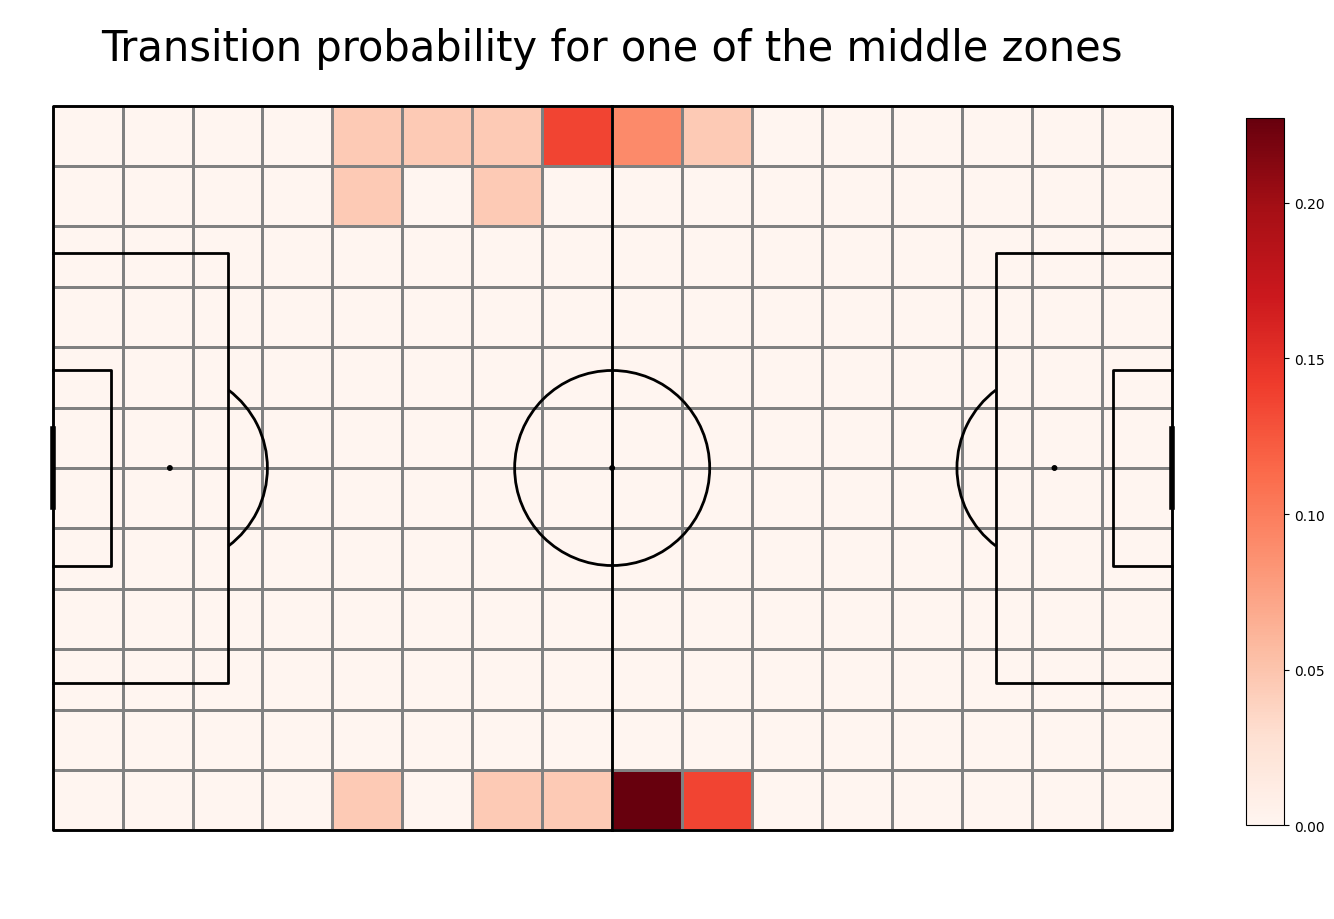

In [264]:
#let's plot it for the zone [1,1] - left down corner
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

#Change the index here to change the zone.
goal["statistic"] = transition_matrices[int(len(transition_matrices)/2)]
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Transition probability for one of the middle zones', fontsize = 30)
plt.show()

## Calculating Expected Threat matrix
- Calculating (probability of a shot)*(probability of a goal given a shot)
- shoot_expected_payoff
- Add this to the move_expected_payoff, which is what the payoff (probability of a goal) will be if the player passes the ball.

In [270]:
result = np.sum(np.sum(transition_matrices_array*xT, axis = 2), axis = 1).reshape(13,17).T

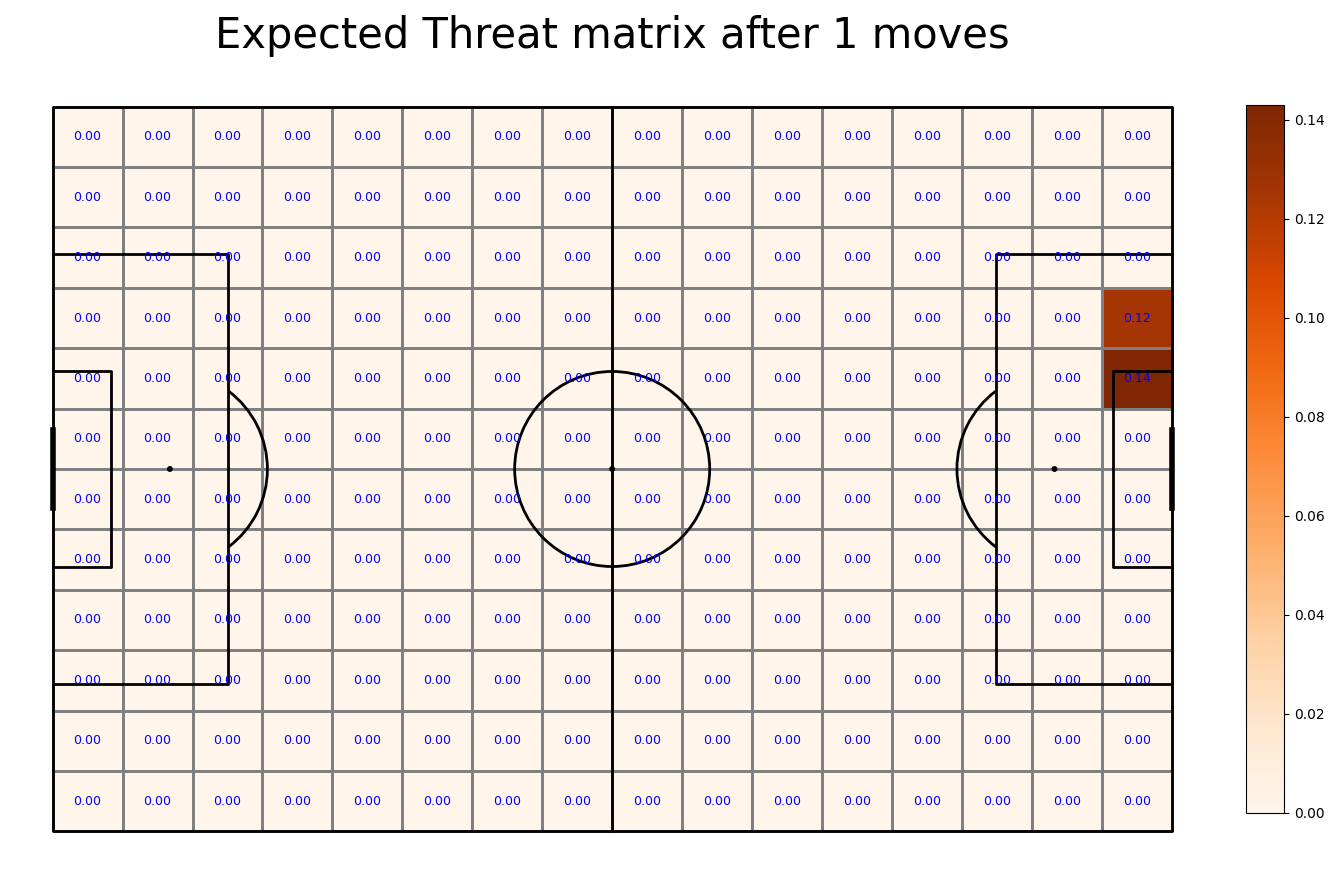

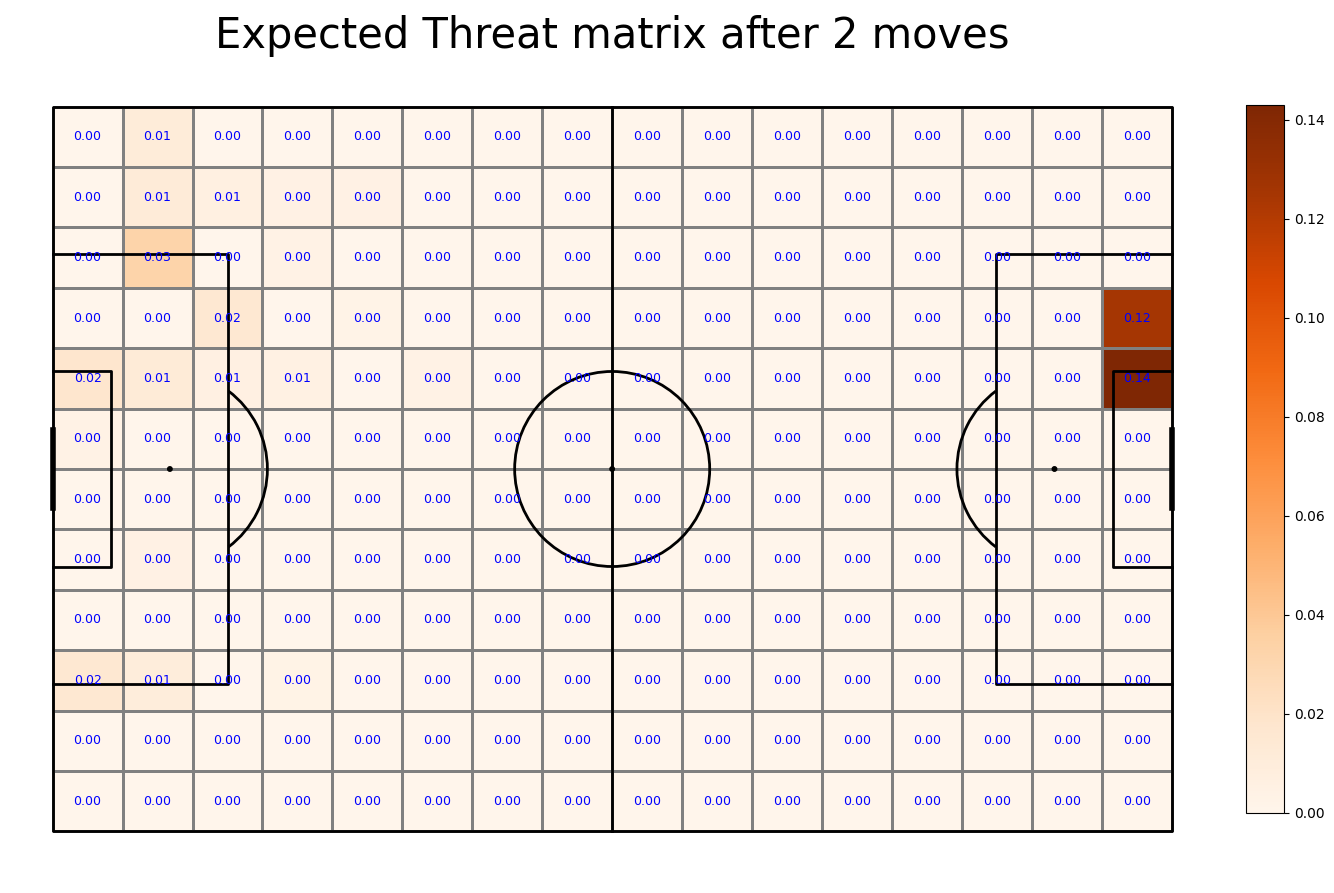

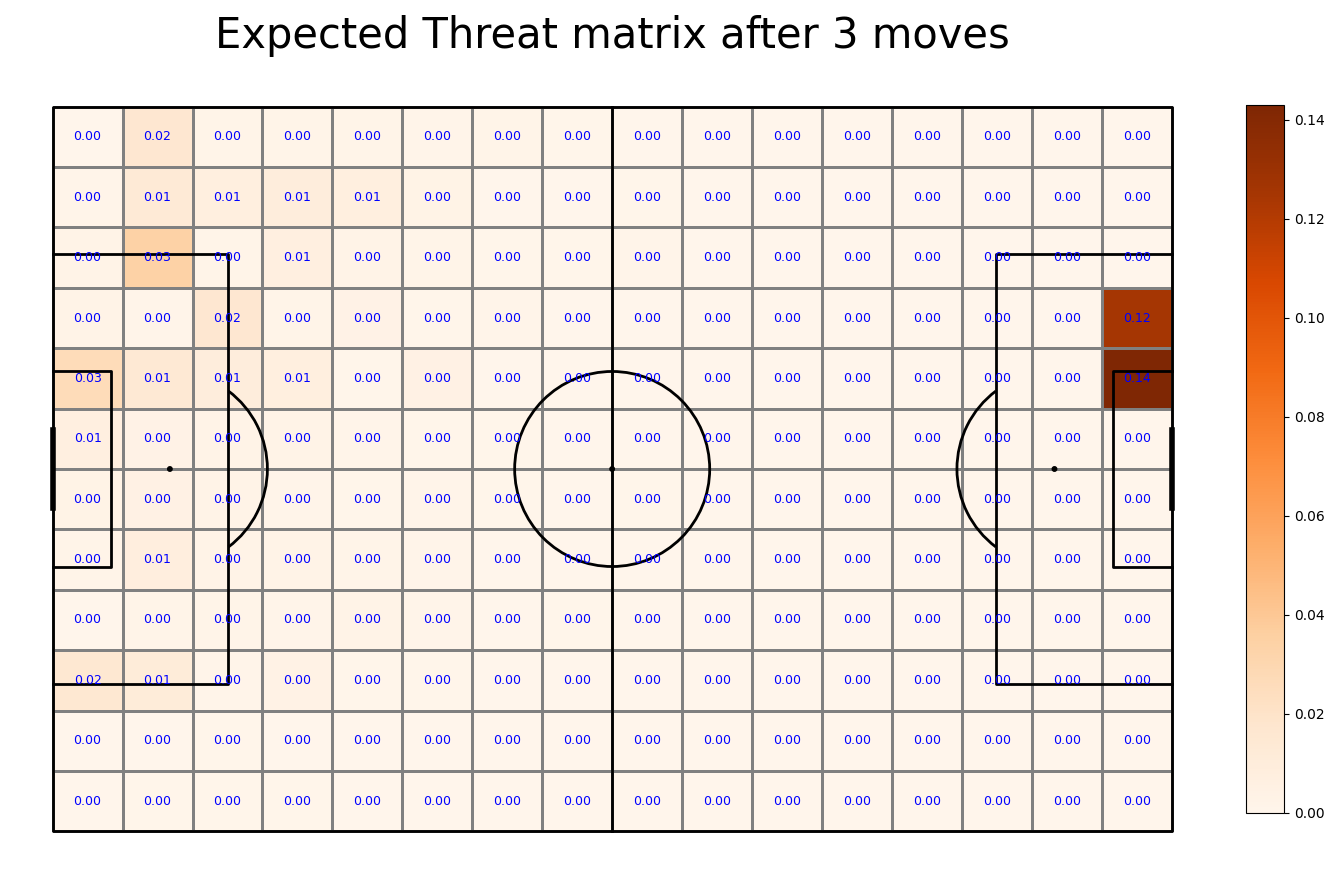

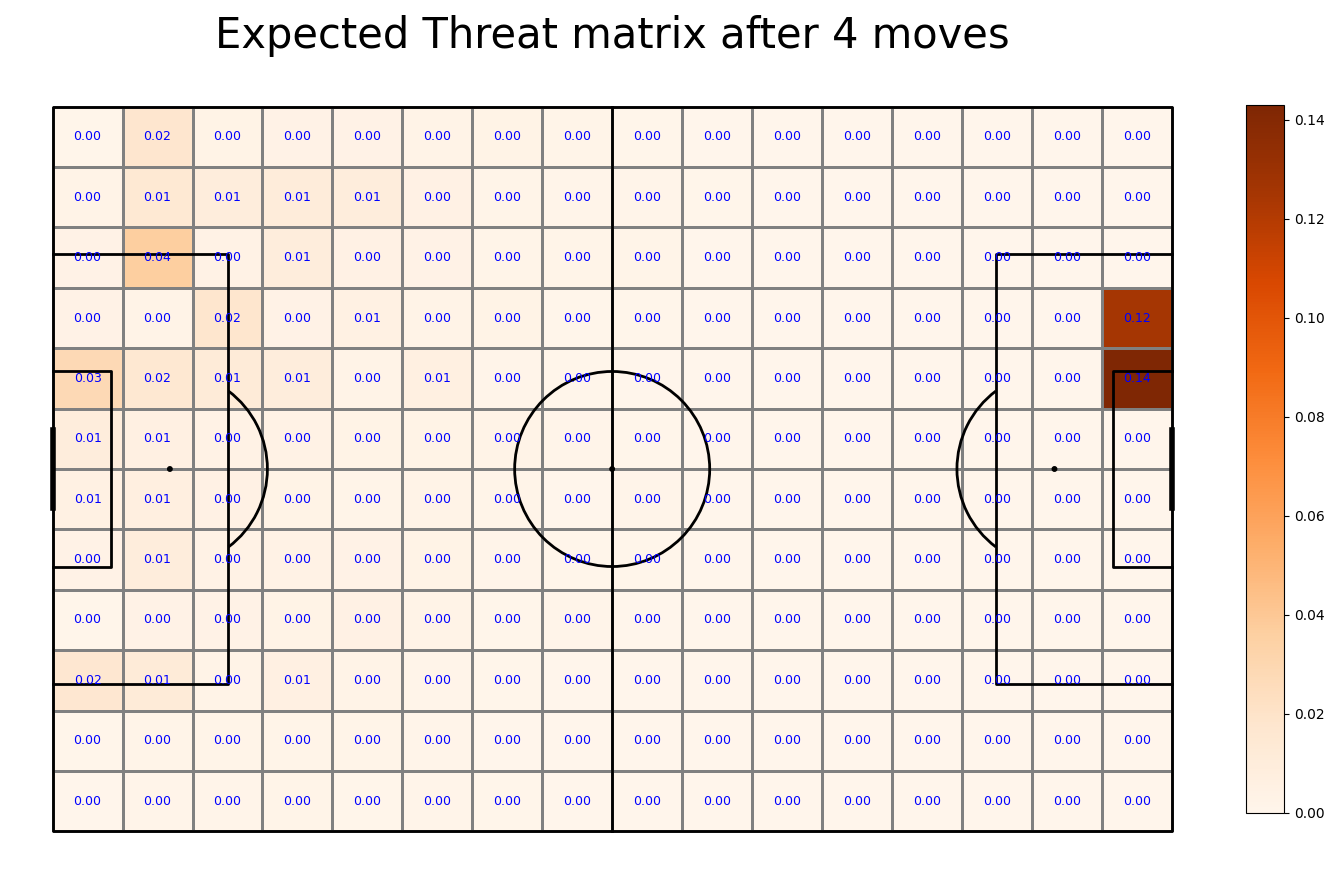

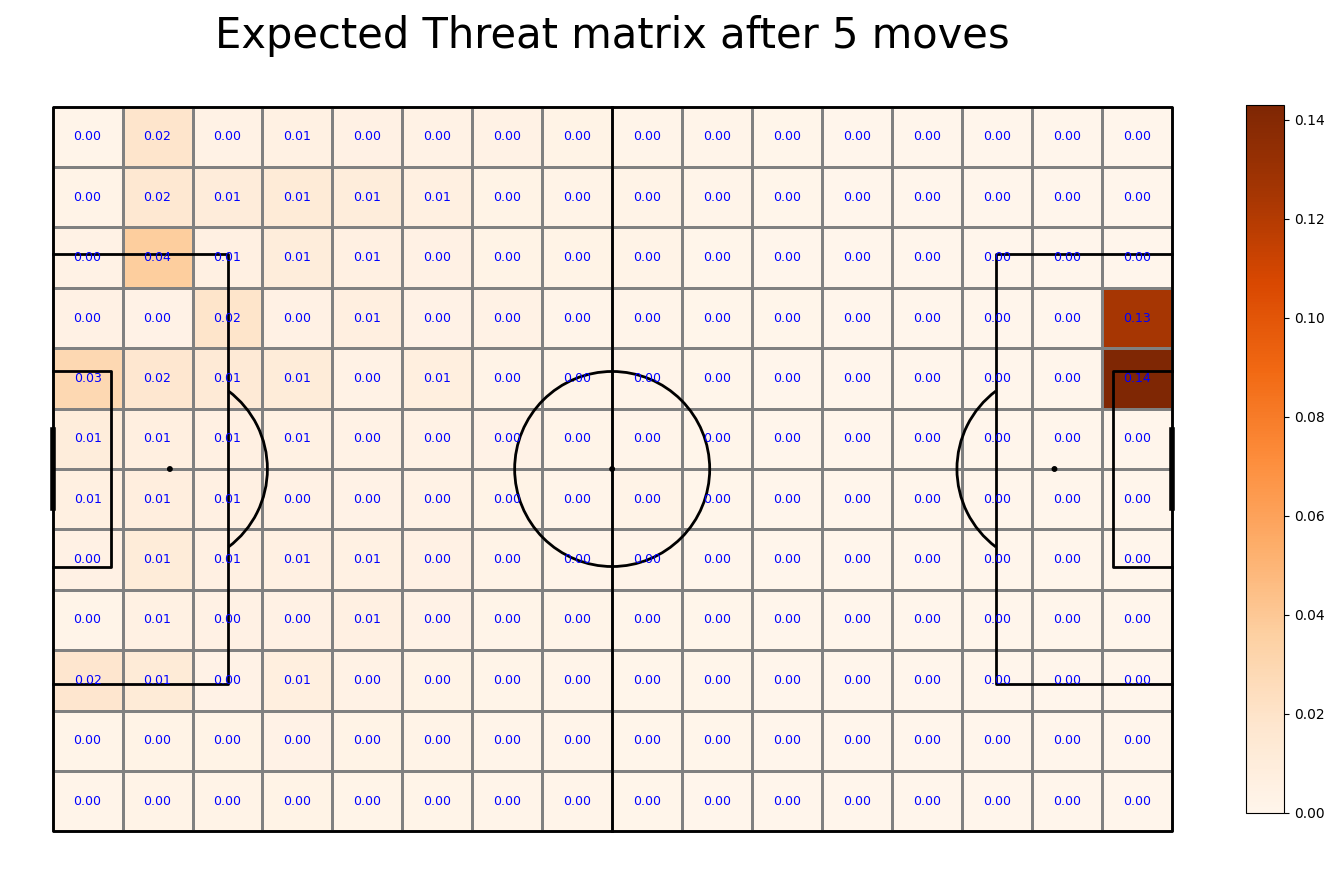

In [271]:
transition_matrices_array = np.array(transition_matrices)
xT = np.zeros((12, 16))
# xT = np.zeros((192,12, 16))
for i in range(5):
    shoot_expected_payoff = goal_probability*shot_probability
    move_expected_payoff = move_probability*(np.sum(np.sum(transition_matrices_array[:192]*xT, axis = 2), axis = 1).reshape(16,12).T)
    xT = shoot_expected_payoff + move_expected_payoff

    #let's plot it!
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.01, title_space=0, endnote_space=0)
    goal["statistic"] = xT
    pcm  = pitch.heatmap(goal, cmap='Oranges', edgecolor='grey', ax=ax['pitch'])
    labels = pitch.label_heatmap(goal, color='blue', fontsize=9,
                             ax=ax['pitch'], ha='center', va='center', str_format="{0:,.2f}", zorder = 3)
    #legend to our plot
    ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
    cbar = plt.colorbar(pcm, cax=ax_cbar)
    txt = 'Expected Threat matrix after ' +  str(i+1) + ' moves'
    fig.suptitle(txt, fontsize = 30)
    plt.show()

## Applying xT value to moving actions
- Calculate for progressive and successful events the xT added
- From the matrix we get the xT value for starting and ending zone and subtract the first one from the latter one
- The other would be to keep all moving the ball actions, calculate xT for the successful ones and assign -xT value of the starting zone for the unsuccessful ones.

In [274]:
#only successful
successful_moves = move_df[move_df['nextEvent']=="Ball Receipt*"]
#calculatexT
successful_moves["xT_added"] = successful_moves.apply(lambda row: xT[row.end_sector[1] - 1][row.end_sector[0] - 1]
                                                      - xT[row.start_sector[1] - 1][row.start_sector[0] - 1], axis = 1)
#only progressive
value_adding_actions = successful_moves.loc[successful_moves["xT_added"] > 0]

## Finding out players with highest xT
- Find out which players who played more than 400 minutes scored the best in possesion-adjusted xT per 90

In [277]:
value_adding_actions

,id,index,period,timestamp,minute,second,possession,obv_for_after,obv_for_before,obv_for_net,...,foul_committed.offensive,nextEvent,kickedOut,x,y,end_x,end_y,start_sector,end_sector,xT_added
7,621b03c3-79ce-48f6-a123-4ff7f92b0201,8,1,00:00:01.691,0,1,2,0.014085,0.017105,-0.003020,...,NaN,Ball Receipt*,0,50.8,45.6,34.8,50.8,"(8, 8)","(5, 9)",4.566092e-03
20,deaca0ce-67cf-484b-a599-fc44e2b7a8f8,21,1,00:00:15.731,0,15,3,0.149671,0.027001,0.122671,...,NaN,Ball Receipt*,0,105.7,6.1,109.1,32.5,"(16, 1)","(16, 6)",9.445986e-07
29,0ca0239b-f9f8-48b1-ad63-ec17a52a26d5,30,1,00:00:24.847,0,24,4,0.022385,0.016955,0.005430,...,NaN,Ball Receipt*,0,93.9,0.1,87.2,3.5,"(14, 1)","(13, 1)",2.898417e-05
32,5c56e968-e897-4024-b359-9600f761a12a,33,1,00:00:28.340,0,28,4,0.027243,0.021767,0.005476,...,NaN,Ball Receipt*,0,85.9,5.2,80.2,36.4,"(13, 1)","(12, 6)",4.882133e-05
44,9f3de28c-869c-4b06-87fe-bdf16c5d7f29,45,1,00:00:52.969,0,52,5,0.010673,0.009820,0.000853,...,NaN,Ball Receipt*,0,15.4,51.7,34.0,7.3,"(3, 9)","(5, 2)",5.424060e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21293,95626242-4c55-4d21-8ef2-b9845b56b553,3437,2,00:47:58.401,92,58,146,0.020513,0.027543,-0.007031,...,NaN,Ball Receipt*,0,99.2,74.5,81.9,74.1,"(15, 12)","(12, 12)",1.273306e-04
21296,195e980e-de1f-40e3-b429-63447607c5f3,3440,2,00:48:01.000,93,1,146,0.015219,0.020162,-0.004943,...,NaN,Ball Receipt*,0,79.2,73.9,59.3,73.5,"(12, 12)","(9, 12)",6.359990e-04
21305,03d933cf-2e0e-4dd0-b342-7ee4b54c1fde,3449,2,00:48:12.786,93,12,146,0.030619,0.029374,0.001244,...,NaN,Ball Receipt*,0,98.8,71.3,93.3,63.6,"(15, 12)","(14, 11)",2.907640e-06
21314,7bda8640-67ac-4d41-89fb-1903f55683a5,3458,2,00:48:21.785,93,21,146,0.019528,0.023623,-0.004096,...,NaN,Ball Receipt*,0,93.5,76.7,81.7,70.9,"(14, 12)","(12, 12)",1.208592e-04


In [286]:
#group by player
xT_by_player = value_adding_actions.groupby(["player.id","player.name"])["xT_added"].sum().reset_index()

In [312]:
xT_by_player = xT_by_player.sort_values(by='xT_added',ascending=False)

In [314]:
df[['team.name','player.name','player.id','position.name']].dropna().drop_duplicates()

,team.name,player.name,player.id,position.name
4,Tottenham Hotspur Women,Nikola Karczewska,63424.0,Center Forward
5,Tottenham Hotspur Women,Drew Spence,4638.0,Right Defensive Midfield
8,Tottenham Hotspur Women,Molly Bartrip,21021.0,Center Back
11,Tottenham Hotspur Women,Amy Turner,31533.0,Right Center Back
15,Manchester City WFC,Ingrid Filippa Angeldal,62666.0,Right Center Midfield
...,...,...,...,...
20622,Leicester City WFC,Molly Pike,31564.0,Left Defensive Midfield
20625,Leicester City WFC,Shannon O’Brien,135759.0,Left Midfield
20868,Manchester City WFC,Leila Ouahabi El Ouahabi,10163.0,Right Center Back
20883,Manchester City WFC,Stephanie Houghton,10185.0,Left Center Back


In [316]:
team_player = df[['team.name','player.name','player.id']].dropna().drop_duplicates()

In [319]:
team_player_df = \
pd.merge(
    xT_by_player,
    team_player,
    on=['player.name','player.id'],
    how='inner'
)

In [321]:
team_player_df[team_player_df['team.name']=='Manchester City WFC']

,player.id,player.name,xT_added,team.name
0,15570.0,Chloe Kelly,0.692430,Manchester City WFC
1,19416.0,Laura Coombs,0.548546,Manchester City WFC
2,15555.0,Lauren Hemp,0.490860,Manchester City WFC
3,4649.0,Esme Beth Morgan,0.417155,Manchester City WFC
5,10252.0,Alex Greenwood,0.385983,Manchester City WFC
6,4637.0,Ellie Roebuck,0.344107,Manchester City WFC
7,221888.0,Kerstin Yasmijn Casparij,0.316048,Manchester City WFC
8,10163.0,Leila Ouahabi El Ouahabi,0.305272,Manchester City WFC
11,32210.0,Laia Aleixandri López,0.233589,Manchester City WFC
12,25632.0,Yui Hasegawa,0.190873,Manchester City WFC
